# DR Detection_CNN and MobileNet V2

Inisialisasi program yang dibutuhkan untuk menjalankan proses deteksi DR.

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.5 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

Import library kaggle kedalam google colab.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Untuk menjalankan program harus memiliki kode API dari keaggle berupa file bernama kaggle.json dan di import kedalam program.

In [ ]:
import zipfile
from google.colab import files

#upload the kaggle json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fauzyahaprillia","key":"cace8c576de9cf4f1e95679f87f5ec53"}'}

Untuk membuat directory (comment), mengcopy file kaggle.json pada laptop kedalam google colab, dan modify permission atas sebuah directory (izin akses). Dengan adanya permission maka kita bisa melihat akses data sheet.

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mendownload dataset kaggle yang memiliki format zip. Dan mengubah menjadi folder di dalam google colab.

In [ ]:
!kaggle datasets download sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

100% 426M/427M [00:16<00:00, 40.2MB/s]
100% 427M/427M [00:16<00:00, 27.5MB/s]


In [ ]:
#folder is unzipped, may take a few moments to populate

with zipfile.ZipFile('/content/diabetic-retinopathy-224x224-gaussian-filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Program untuk klasifikasi pada diagnosa DR.

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR

Berikut merupakan kode yang digunakan untuk Menghasilkan plot bar horizontal yang menunjukkan jumlah nilai unik dalam kolom "type".

<Axes: >

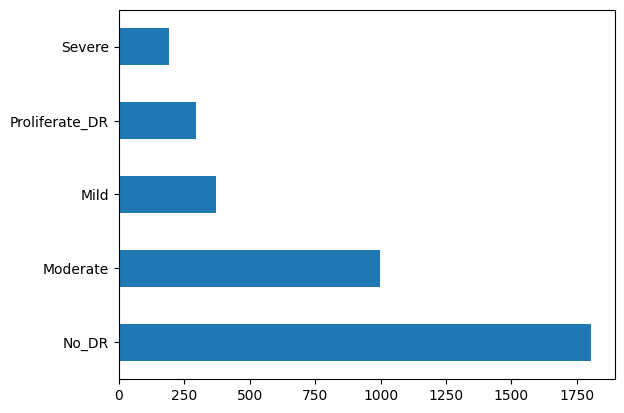

In [ ]:
df['type'].value_counts().plot(kind='barh')

Bagian ini adalah Memperlihatkan diagram batang horizontal yang menunjukkan jumlah label klasifikasi biner unik dalam tipe biner.

<Axes: >

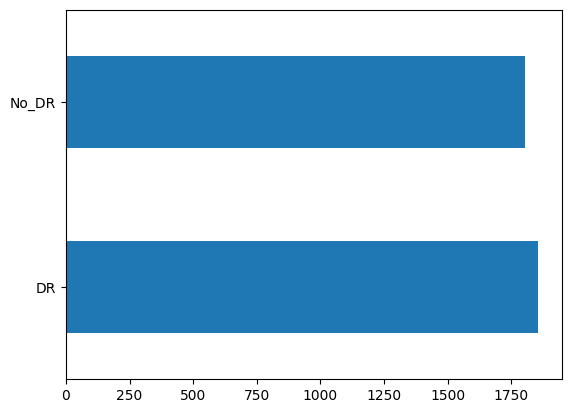

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

Program dibawah merupakan kode yang menunjukkan bagian folder yang akan muncul dibagian kiri layar google colab untuk masing-masing klasifikasi penyakit DR

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



Kode dibawah ini adalah komentar yang menjelaskan bahwa pada program tersebut dilakukan proses pembuatan direktori kerja untuk data latih, validasi, dan tes.

In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


Kode dibawah ini adalah komentar yang menjelaskan bahwa program tersebut dilakukan penyalinan (copy) gambar ke dalam direktori kerja yang sesuai.
Selanjutnya, pada baris kedua, terdapat deklarasi variabel "src_dir" yang berisi alamat direktori asal (source directory) yang merupakan rute absolut dari folder "gaussian_filtered_images/gaussian_filtered_images" di dalam folder "content". Variabel ini akan digunakan pada kode program selanjutnya untuk mengambil dan memindahkan file gambar ke direktori tujuan yang sesuai.


In [ ]:
# Copy images to respective working directory
src_dir = r'/content/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


## MULTICLASS : 5 CLASS (DR, NO_DR, PROLIFERATE_DR, MODERATE, MILD)

**DATA WITHOUT AUGMENTATION PROCESS**

Kode "# Setting up ImageDataGenerator for train/val/test" adalah komentar yang menjelaskan bahwa pada program ini dilakukan pengaturan (setup) objek ImageDataGenerator untuk data latih, validasi, dan tes.

In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

# Setting up ImageDataGenerator for train/val/test with data augmentation for train
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle=True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle=True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle=False)

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


**8 LAYER CNN MODEL**

Berikut adalah komentar dalam kode program yang digunakan untuk menjelaskan bahwa bagian kode yang mengikuti adalah bagian yang digunakan untuk membangun model (model building).

In [ ]:
# Building the model

CNN_model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

CNN_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])


import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches.classes), y=train_batches.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = CNN_model.fit(train_batches,
                    epochs=12,
                    validation_data=val_batches,
                    class_weight=class_weights_dict)

Epoch 1/12
81/81 [==============================] - 28s 131ms/step - loss: 0.6039 - acc: 0.3454 - auc: 0.6844 - f1_score: 0.3951 - cohen_kappa: 0.1818 - val_loss: 0.5898 - val_acc: 0.0527 - val_auc: 0.3292 - val_f1_score: 0.0053 - val_cohen_kappa: -4.2248e-04
Epoch 2/12
81/81 [==============================] - 12s 146ms/step - loss: 0.5143 - acc: 0.4430 - auc: 0.7681 - f1_score: 0.4881 - cohen_kappa: 0.2710 - val_loss: 0.5556 - val_acc: 0.0527 - val_auc: 0.3398 - val_f1_score: 0.0053 - val_cohen_kappa: 0.0000e+00
Epoch 3/12
81/81 [==============================] - 25s 303ms/step - loss: 0.4642 - acc: 0.5152 - auc: 0.8280 - f1_score: 0.5465 - cohen_kappa: 0.3467 - val_loss: 0.5893 - val_acc: 0.0527 - val_auc: 0.3701 - val_f1_score: 0.0053 - val_cohen_kappa: 0.0000e+00
Epoch 4/12
81/81 [==============================] - 13s 164ms/step - loss: 0.4279 - acc: 0.5554 - auc: 0.8526 - f1_score: 0.5821 - cohen_kappa: 0.3924 - val_loss: 0.5825 - val_acc: 0.1073 - val_auc: 0.4024 - val_f1_score: 

Kode ini digunakan untuk menyimpan model yang telah dibangun ke dalam file dengan format tertentu. Metode save() digunakan untuk menyimpan model ke dalam file dengan nama CNN.model.

In [ ]:
CNN_model.save('CNN_5_class.model')

Kode dalam program ini digunakan untuk mengevaluasi performa model yang telah dibangun pada data uji (test data) dengan menggunakan metode evaluate_generator()..
Dalam hal ini, fungsi evaluate_generator() dipanggil dengan parameter test_batches, yang merupakan generator untuk batch data uji, dan verbose yang diatur ke 1 untuk menampilkan informasi yang lebih rinci selama proses evaluasi.


In [ ]:
acc = CNN_model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc[1])

<ipython-input-18-5d17ab57d9c3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = CNN_model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 2s 115ms/step - loss: 0.4941 - acc: 0.5091 - auc: 0.7915 - f1_score: 0.3580 - cohen_kappa: 0.0617
Accuracy:  0.5090909004211426


In [ ]:
# Get the maximum accuracy and minimum test loss
max_accuracy = max(history.history['acc'])
min_test_loss = min(history.history['val_loss'])

# Print the results
print('Highest accuracy:', max_accuracy)
print('Test loss:', min_test_loss)

Highest accuracy: 0.6209992170333862
Test loss: 0.3164735734462738


Untuk mengimpor library matplotlib.pyplot, yang merupakan library untuk visualisasi data dalam bahasa pemrograman Python

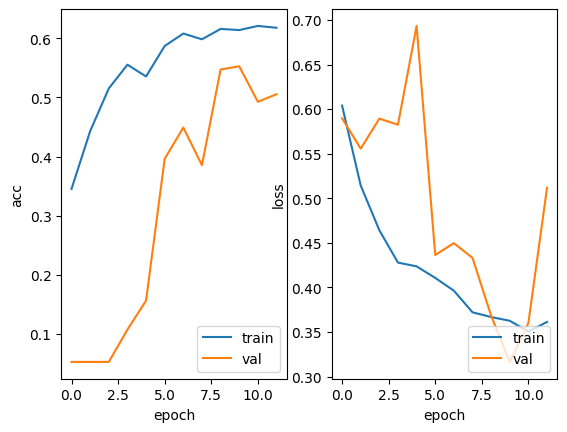

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


kode dibawah ini digunakan untuk memberikan informasi atau penjelasan tentang tugas memprediksi atau estimasi label dari gambar uji.

In [ ]:
#  Predict the label of the test_images
pred = CNN_model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 [==============================] - 2s 80ms/step
The first 5 predictions: ['No_DR', 'No_DR', 'No_DR', 'No_DR', 'Mild']


Modul "classification_report" yang diimpor dari "sklearn.metrics" merupakan salah satu modul yang digunakan untuk mengevaluasi kinerja model klasifikasi. Modul ini menyediakan fungsi untuk menghasilkan laporan klasifikasi yang menunjukkan seberapa baik model dapat memprediksi label kelas untuk setiap sampel dalam data uji.

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test.type)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.47636
Precision: 0.24803
Recall: 0.47636
F1 Score: 0.32476
Cohen Kappa Score: -0.00087
                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        56
      Moderate       0.00      0.00      0.00       150
         No_DR       0.49      0.96      0.65       271
Proliferate_DR       0.00      0.00      0.00        44
        Severe       0.11      0.07      0.09        29

      accuracy                           0.48       550
     macro avg       0.12      0.21      0.15       550
  weighted avg       0.25      0.48      0.32       550



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

Modul "confusion_matrix" digunakan untuk menghitung matriks konfusi, yaitu sebuah tabel yang menunjukkan jumlah klasifikasi benar dan salah pada setiap kelas yang ada dalam data uji.
Modul "seaborn" adalah sebuah library Python untuk visualisasi data yang memungkinkan kita untuk membuat grafik dan plot yang informatif dan estetis. Dalam konteks evaluasi model klasifikasi, modul "seaborn" dapat digunakan untuk membuat heatmap dari matriks konfusi, yang dapat membantu kita memahami dengan lebih mudah dan cepat pola-pola dalam klasifikasi yang dilakukan oleh model.

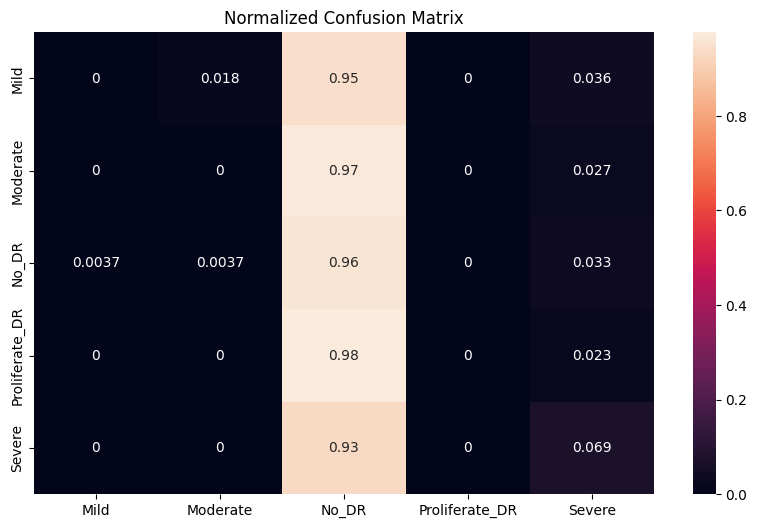

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

**WITH AUGMENTATION PROCESS**

Kode "batch_size = 32" merupakan sebuah perintah dalam bahasa pemrograman Python yang menetapkan nilai 32 sebagai ukuran batch yang akan digunakan dalam proses pelatihan model.

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

train_batches2 = train_datagen.flow_from_directory(train_path,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  batch_size=batch_size)

val_batches2 = val_datagen.flow_from_directory(val_path,
                                              target_size=(224,224),
                                              shuffle=True,
                                              batch_size=batch_size)

test_batches2 = test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                shuffle=False,
                                                batch_size=batch_size)

print('Number of train batches:', len(train_batches2))
print('Number of validation batches:', len(val_batches2))
print('Number of test batches:', len(test_batches2))

print('Total number of train images:', len(train_batches2) * batch_size)
print('Total number of validation images:', len(val_batches2) * batch_size)
print('Total number of test images:', len(test_batches2) * batch_size)

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Number of train batches: 81
Number of validation batches: 18
Number of test batches: 18
Total number of train images: 2592
Total number of validation images: 576
Total number of test images: 576


# 8 Layer CNN Model

Kode "# Building the model" adalah sebuah komentar (comment) dalam bahasa pemrograman Python yang menunjukkan bahwa akan mulai membuat model pembelajaran mesin pada bagian kode selanjutnya.

In [ ]:
# Building the model

CNNaug_model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

CNNaug_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])


import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches2.classes), y=train_batches2.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = CNNaug_model.fit(train_batches2,
                    epochs=12,
                    validation_data=val_batches2,
                    class_weight=class_weights_dict)

Epoch 1/12
81/81 [==============================] - 49s 512ms/step - loss: 0.5354 - acc: 0.5113 - auc: 0.7759 - f1_score: 0.5225 - cohen_kappa: 0.2939 - val_loss: 0.5520 - val_acc: 0.0800 - val_auc: 0.3472 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 2/12
81/81 [==============================] - 42s 524ms/step - loss: 0.4932 - acc: 0.4910 - auc: 0.7777 - f1_score: 0.5131 - cohen_kappa: 0.2910 - val_loss: 0.6028 - val_acc: 0.0800 - val_auc: 0.2547 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 3/12
81/81 [==============================] - 42s 521ms/step - loss: 0.4777 - acc: 0.5230 - auc: 0.7965 - f1_score: 0.5416 - cohen_kappa: 0.3190 - val_loss: 0.5787 - val_acc: 0.0800 - val_auc: 0.2403 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 4/12
81/81 [==============================] - 40s 494ms/step - loss: 0.4707 - acc: 0.5016 - auc: 0.7843 - f1_score: 0.5257 - cohen_kappa: 0.3019 - val_loss: 0.7807 - val_acc: 0.4927 - val_auc: 0.6764 - val_f1_score: 0

dibawah ini adalah perintah atau fungsi dalam bahasa pemrograman Python untuk menyimpan model neural network pada file yang diberi nama 'CNNaug_5_class.model' dengan format yang disebut sebagai Keras model format.

In [ ]:
CNNaug_model.save('CNNaug_5_class.model')

In [ ]:
acc = CNNaug_model.evaluate_generator(test_batches2, verbose=1)
print("Accuracy: ", acc[1])

<ipython-input-27-e8fa5fc47531>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = CNNaug_model.evaluate_generator(test_batches2, verbose=1)


18/18 [==============================] - 10s 477ms/step - loss: 0.3214 - acc: 0.6145 - auc: 0.8831 - f1_score: 0.6090 - cohen_kappa: 0.4173
Accuracy:  0.614545464515686


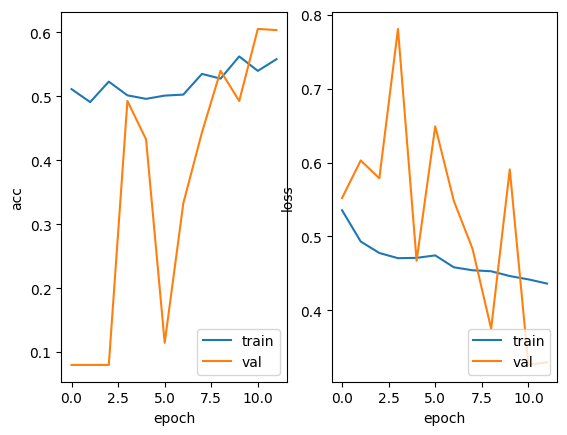

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


In [ ]:
#  Predict the label of the test_images
pred = CNNaug_model.predict(test_batches2)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches2.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 [==============================] - 6s 348ms/step
The first 5 predictions: ['Mild', 'Moderate', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test.type)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.31636
Precision: 0.3224
Recall: 0.31636
F1 Score: 0.31652
Cohen Kappa Score: -0.02101
                precision    recall  f1-score   support

          Mild       0.09      0.07      0.08        56
      Moderate       0.27      0.19      0.22       150
         No_DR       0.47      0.50      0.48       271
Proliferate_DR       0.05      0.07      0.06        44
        Severe       0.07      0.14      0.10        29

      accuracy                           0.32       550
     macro avg       0.19      0.19      0.19       550
  weighted avg       0.32      0.32      0.32       550



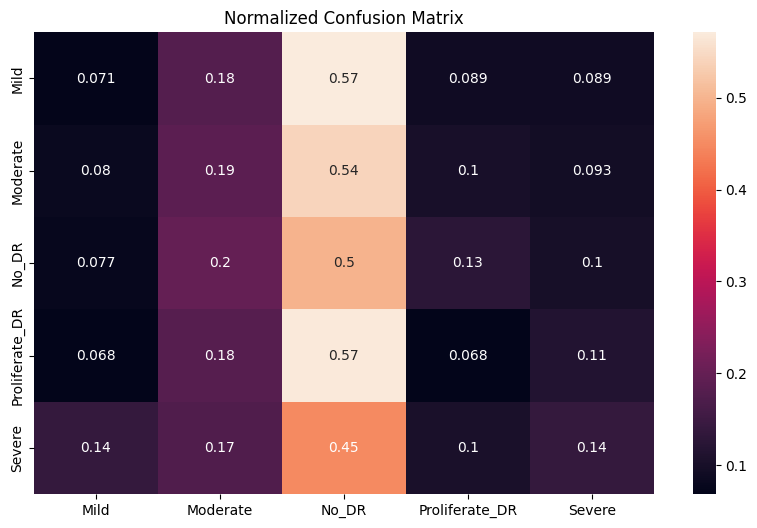

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

# DR PREDICTION SECTION

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNN_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('No_DR')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('Mild')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 0s 195ms/step
Mild


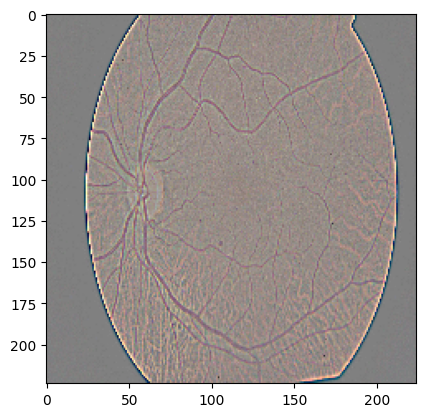

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class2(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNNaug_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('No_DR')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('Mild')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 0s 189ms/step
Severe


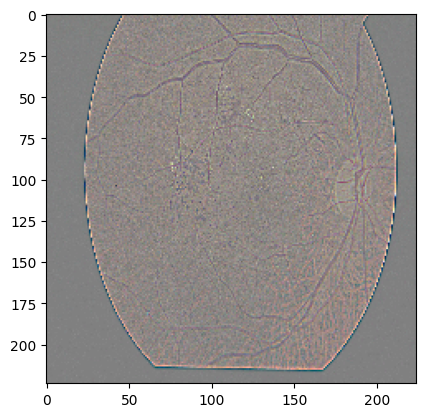

In [ ]:
predict_class2('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png')

1/1 [==============================] - 0s 182ms/step
Proliferate DR


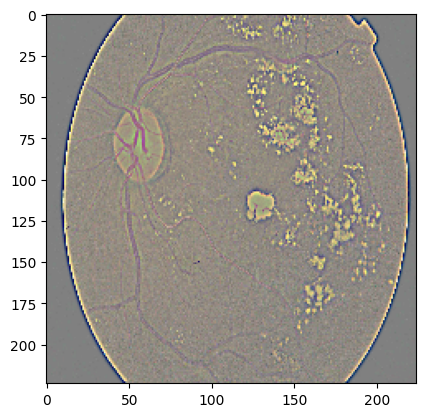

In [ ]:
predict_class2('/content/gaussian_filtered_images/gaussian_filtered_images/Severe/0104b032c141.png')

# MOBILENETV2

**NO AUGMENTATION**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

MobileNetV2_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

MobileNetV2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc',
                       'AUC',
                       tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),
                       tensorflow_addons.metrics.CohenKappa(num_classes=5)])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches.classes), y=train_batches.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = MobileNetV2_model.fit(train_batches,
                    epochs=12,
                    validation_data=val_batches,
                    class_weight=class_weights_dict)


Epoch 1/12
81/81 [==============================] - 185s 2s/step - loss: 0.4731 - acc: 0.4934 - auc: 0.7730 - f1_score: 0.5169 - cohen_kappa: 0.2890 - val_loss: 0.3302 - val_acc: 0.6073 - val_auc: 0.8849 - val_f1_score: 0.5978 - val_cohen_kappa: 0.4252
Epoch 2/12
81/81 [==============================] - 135s 2s/step - loss: 0.3820 - acc: 0.6483 - auc: 0.8999 - f1_score: 0.6532 - cohen_kappa: 0.4941 - val_loss: 0.3055 - val_acc: 0.6055 - val_auc: 0.8963 - val_f1_score: 0.5778 - val_cohen_kappa: 0.4308
Epoch 3/12
81/81 [==============================] - 152s 2s/step - loss: 0.3644 - acc: 0.6721 - auc: 0.9129 - f1_score: 0.6790 - cohen_kappa: 0.5268 - val_loss: 0.2977 - val_acc: 0.6527 - val_auc: 0.9026 - val_f1_score: 0.6586 - val_cohen_kappa: 0.5066
Epoch 4/12
81/81 [==============================] - 153s 2s/step - loss: 0.3459 - acc: 0.7002 - auc: 0.9228 - f1_score: 0.7056 - cohen_kappa: 0.5649 - val_loss: 0.2853 - val_acc: 0.6509 - val_auc: 0.9090 - val_f1_score: 0.6414 - val_cohen_ka

In [ ]:
MobileNetV2_model.save('MobileNetV2_5_class.model')

In [ ]:
acc = MobileNetV2_model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc[1])

<ipython-input-40-2755bb85a7a5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = MobileNetV2_model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 24s 1s/step - loss: 0.2600 - acc: 0.7055 - auc: 0.9274 - f1_score: 0.7061 - cohen_kappa: 0.5698
Accuracy:  0.7054545283317566


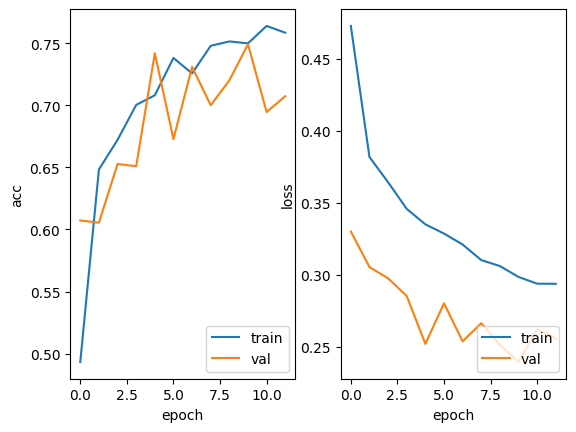

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
#  Predict the label of the test_images
pred = MobileNetV2_model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 [==============================] - 44s 2s/step
The first 5 predictions: ['Mild', 'Proliferate_DR', 'Mild', 'Mild', 'Mild']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test.type)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.30182
Precision: 0.32374
Recall: 0.30182
F1 Score: 0.30647
Cohen Kappa Score: -0.01963
                precision    recall  f1-score   support

          Mild       0.02      0.02      0.02        56
      Moderate       0.25      0.13      0.17       150
         No_DR       0.49      0.51      0.50       271
Proliferate_DR       0.13      0.11      0.12        44
        Severe       0.03      0.10      0.05        29

      accuracy                           0.30       550
     macro avg       0.18      0.17      0.17       550
  weighted avg       0.32      0.30      0.31       550



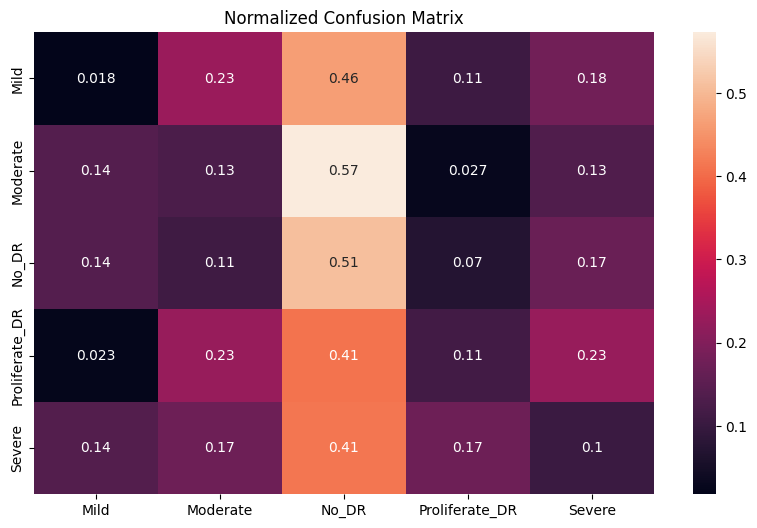

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

**AUGMENTATION**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

MobileNetV2aug_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])

MobileNetV2aug_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc',
                       'AUC',
                       tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),
                       tensorflow_addons.metrics.CohenKappa(num_classes=5)])

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches2.classes), y=train_batches2.classes)

# convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

history = MobileNetV2aug_model.fit(train_batches2,
                    epochs=12,
                    validation_data=val_batches2,
                    class_weight=class_weights_dict)


Epoch 1/12
81/81 [==============================] - 220s 3s/step - loss: 0.4809 - acc: 0.4980 - auc: 0.7721 - f1_score: 0.5358 - cohen_kappa: 0.3106 - val_loss: 0.3554 - val_acc: 0.5691 - val_auc: 0.8484 - val_f1_score: 0.5711 - val_cohen_kappa: 0.3897
Epoch 2/12
81/81 [==============================] - 185s 2s/step - loss: 0.4050 - acc: 0.6046 - auc: 0.8774 - f1_score: 0.6186 - cohen_kappa: 0.4351 - val_loss: 0.3152 - val_acc: 0.6418 - val_auc: 0.8966 - val_f1_score: 0.6417 - val_cohen_kappa: 0.4875
Epoch 3/12
81/81 [==============================] - 183s 2s/step - loss: 0.3943 - acc: 0.6159 - auc: 0.8887 - f1_score: 0.6213 - cohen_kappa: 0.4516 - val_loss: 0.3065 - val_acc: 0.5982 - val_auc: 0.8946 - val_f1_score: 0.6009 - val_cohen_kappa: 0.4260
Epoch 4/12
81/81 [==============================] - 182s 2s/step - loss: 0.3801 - acc: 0.6409 - auc: 0.9019 - f1_score: 0.6468 - cohen_kappa: 0.4837 - val_loss: 0.2944 - val_acc: 0.6364 - val_auc: 0.9046 - val_f1_score: 0.6311 - val_cohen_ka

In [ ]:
MobileNetV2aug_model.save('MobileNetV2aug_5_class.model')

In [ ]:
acc = MobileNetV2aug_model.evaluate_generator(test_batches2, verbose=1)
print("Accuracy: ", acc[1])

<ipython-input-48-9388d01bc185>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = MobileNetV2aug_model.evaluate_generator(test_batches2, verbose=1)


18/18 [==============================] - 30s 2s/step - loss: 0.2747 - acc: 0.6909 - auc: 0.9240 - f1_score: 0.6898 - cohen_kappa: 0.5536
Accuracy:  0.6909090876579285


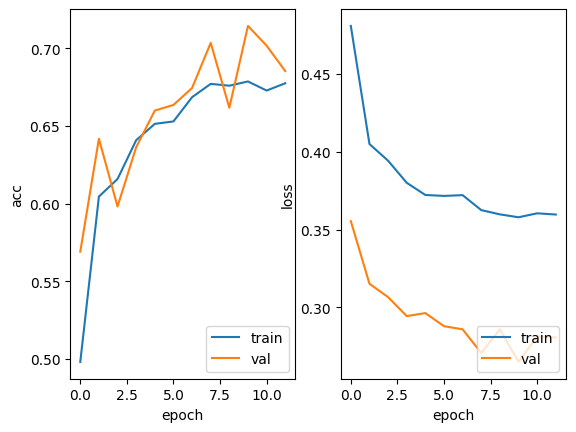

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
#  Predict the label of the test_images
pred = MobileNetV2aug_model.predict(test_batches2)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches2.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

18/18 [==============================] - 32s 2s/step
The first 5 predictions: ['Mild', 'Proliferate_DR', 'Mild', 'Mild', 'Mild']


Accuracy: 0.3
Precision: 0.3329
Recall: 0.3
F1 Score: 0.30926
Cohen Kappa Score: -0.00831
                precision    recall  f1-score   support

          Mild       0.03      0.05      0.04        56
      Moderate       0.25      0.12      0.16       150
         No_DR       0.51      0.50      0.51       271
Proliferate_DR       0.10      0.11      0.11        44
        Severe       0.04      0.10      0.06        29

      accuracy                           0.30       550
     macro avg       0.19      0.18      0.18       550
  weighted avg       0.33      0.30      0.31       550



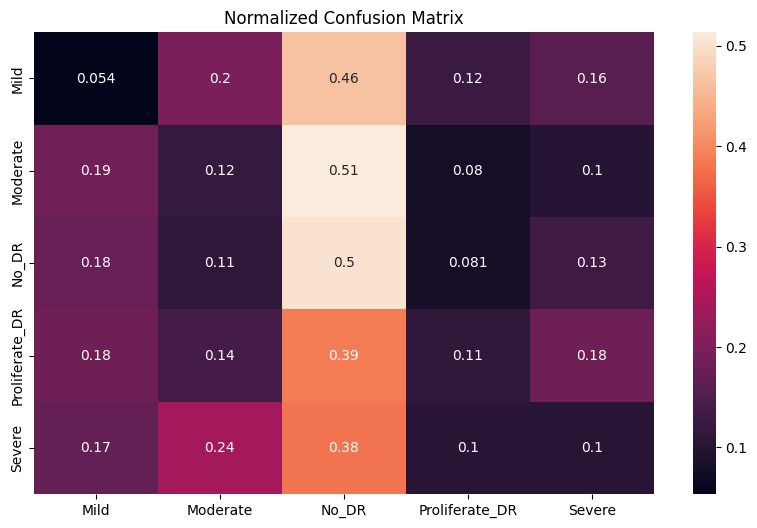

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test.type)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, pred),5))
print(classification_report(y_test, pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

# DR PREDICTION SECTION

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("MobileNetV2_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('Mild')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('No_DR')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 1s 1s/step
Proliferate DR


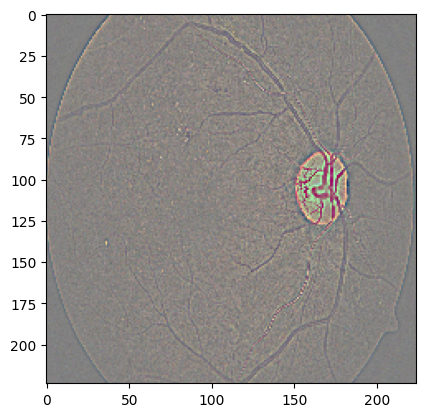

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/03a7f4a5786f.png')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("MobileNetV2aug_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('Mild')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('No_DR')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 1s 1s/step
Mild


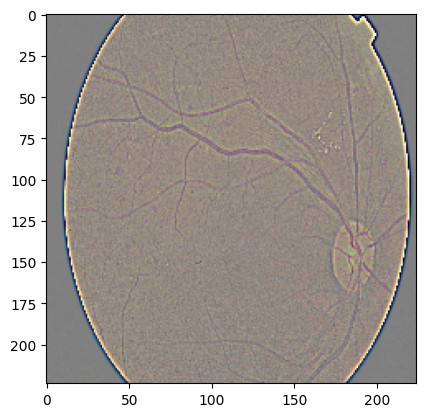

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/0ad7f631dedb.png')

1/1 [==============================] - 1s 1s/step
No_DR


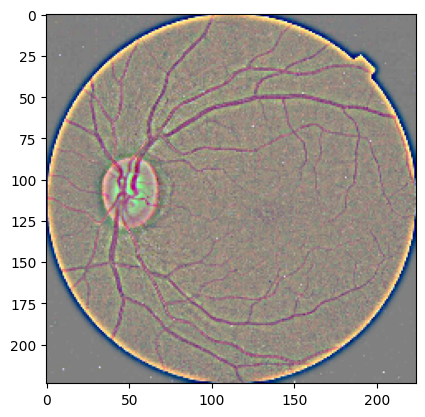

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR/0125fbd2e791.png')

1/1 [==============================] - 1s 962ms/step
Moderate


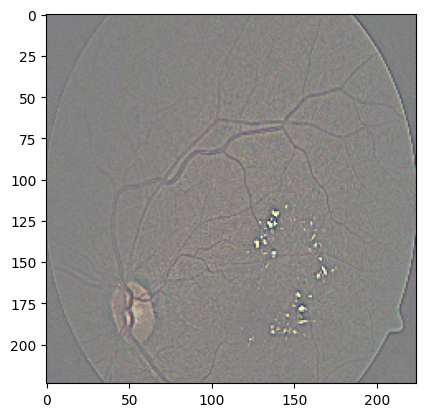

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Moderate/052d9a3fe55a.png')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNNaug_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('Mild')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('No_DR')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 0s 466ms/step
Mild


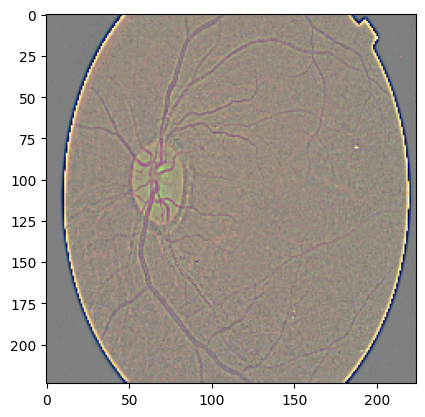

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/0a61bddab956.png')

1/1 [==============================] - 0s 308ms/step
Moderate


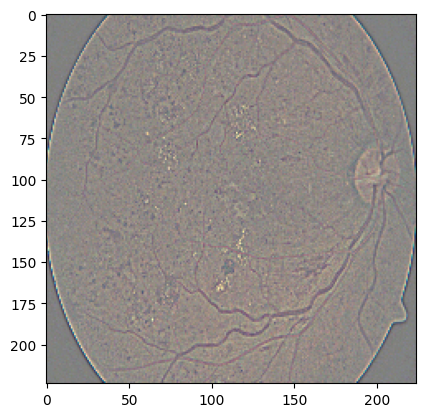

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Severe/72595230840c.png')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("CNN_5_class.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)

    if per==0:
        print('Mild')
    elif per==1:
        print('Moderate')
    elif per==2:
        print('No_DR')
    elif per==3:
        print('Severe')
    elif per==4:
        print('Proliferate DR')

1/1 [==============================] - 0s 283ms/step
Moderate


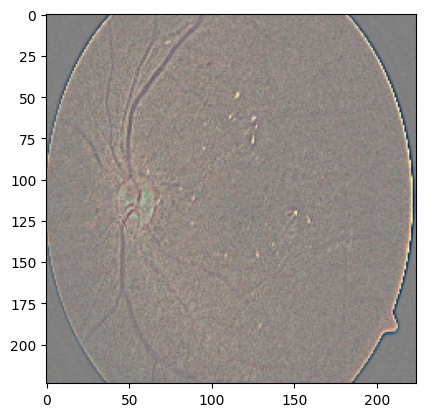

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Mild/0d310aba6373.png')

1/1 [==============================] - 0s 278ms/step
Moderate


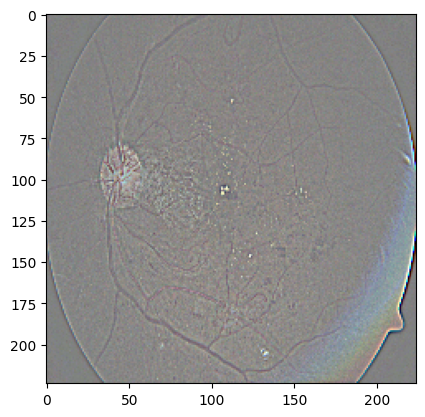

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0ada12c0e78f.png')

1/1 [==============================] - 0s 374ms/step
No_DR


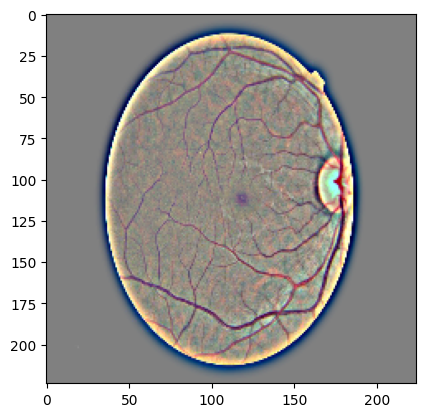

In [ ]:
predict_class('/content/gaussian_filtered_images/gaussian_filtered_images/No_DR/01d9477b1171.png')

Kesimpulan :

Model MobileNetV2 memiliki arsitektur yang lebih kompleks dan lebih banyak menggunakan kombinasi layer konvolusi seperti depthwise separable convolutions dan pointwise convolutions, sehingga lebih efektif dalam mempelajari fitur-fitur kompleks pada gambar. Selain itu, MobileNetV2 juga sudah dilatih sebelumnya pada dataset besar yaitu ImageNet, yang berisi jutaan gambar. Pelatihan awal pada dataset tersebut memungkinkan model untuk mempelajari fitur-fitur umum yang dapat digunakan untuk berbagai tugas termasuk tugas klasifikasi gambar yang spesifik. Sedangkan model CNN dilatih dari awal tanpa pelatihan awal, sehingga performanya mungkin tidak optimal. Oleh karena itu, diasumsikan bahwa MobileNetV2 memiliki performa yang lebih baik dibandingkan dengan model CNN.
